In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN

## Fetching and Cleaning Data

In [ ]:
# fetch dataset
myocardial_infarction_complications = fetch_ucirepo(id=579)

# data (as pandas dataframes)
X = myocardial_infarction_complications.data.features
y = myocardial_infarction_complications.data.targets

# Creating DataFrame for the problem statement
target = y["ZSN"]
df = X.copy()
df["ZSN"] = target
df.head()
df.drop('ZSN_A', axis=1, inplace=True)

In [ ]:
# See if any of the columns have string data
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Column '{column}' contains strings.")

In [ ]:
# Seeing percent of values which are unique in a column
percent_25 = []
percent_50 = []
percent_75 = []
for column in df.columns:
    unique = df[column].nunique()
    total_values = df[column].count()
    if total_values == 0:
        percentage_unique = 0
    else:
        percentage_unique = (unique / total_values) * 100
    if percentage_unique >= 75:
        percent_75.append(column)
    elif percentage_unique >= 50:
        percent_50.append(column)
    elif percentage_unique >= 25:
        percent_25.append(column)

print(percent_75)
print(percent_50)
print(percent_25)

df = df.drop("KFK_BLOOD", axis=1)
df.head()

['KFK_BLOOD']
[]
[]


,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,ZSN
0,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0
2,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
3,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
4,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0


Correlation with 'ZSN':
ZSN              1.000000
AGE              0.143826
endocr_01        0.126239
NA_R_3_n         0.122687
zab_leg_01       0.113460
                   ...   
GEPAR_S_n       -0.046392
ritm_ecg_p_01   -0.064612
K_SH_POST       -0.083462
SEX             -0.097490
IBS_NASL        -0.182574
Name: ZSN, Length: 110, dtype: float64


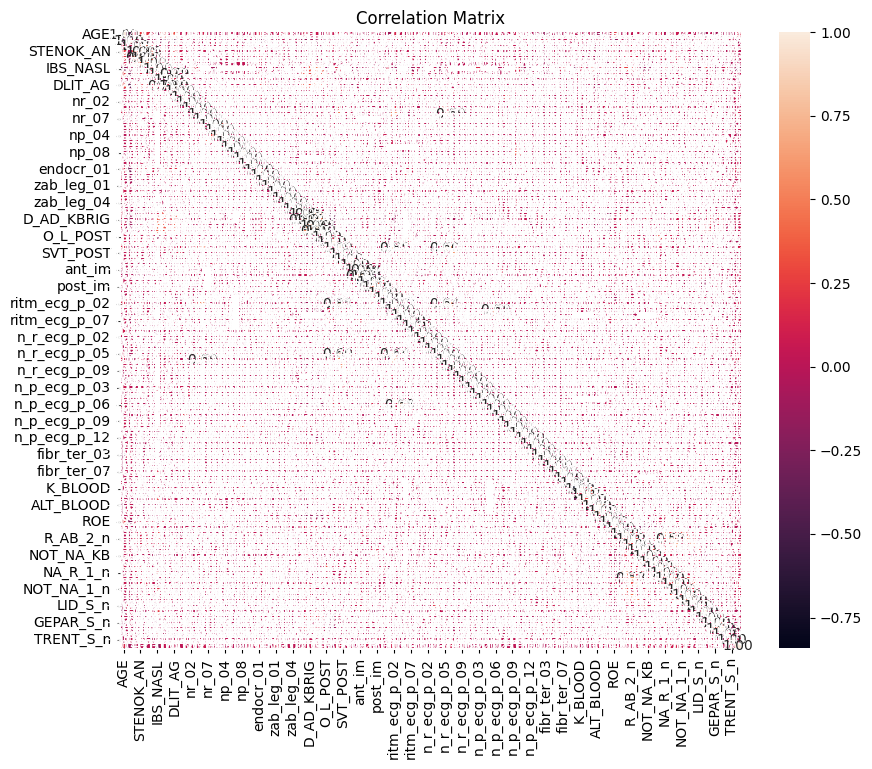


Selected features based on the threshold of 0.075:
['AGE', 'endocr_01', 'NA_R_3_n', 'zab_leg_01', 'n_r_ecg_p_06', 'ritm_ecg_p_02', 'NA_R_2_n', 'nr_04', 'MP_TP_POST', 'R_AB_3_n', 'NOT_NA_KB', 'lat_im', 'K_SH_POST', 'SEX', 'IBS_NASL']


<ipython-input-7-64ae5dc2a790>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_selection['ZSN'] = df['ZSN']


,AGE,endocr_01,NA_R_3_n,zab_leg_01,n_r_ecg_p_06,ritm_ecg_p_02,NA_R_2_n,nr_04,MP_TP_POST,R_AB_3_n,NOT_NA_KB,lat_im,K_SH_POST,SEX,IBS_NASL,ZSN
0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1,NaN,0
1,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0
2,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,NaN,0
3,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,0.0,0,NaN,1
4,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,NaN,0


In [ ]:
# Feature Selection
corr_matrix = df.corr(method='spearman')
target_correlation = corr_matrix['ZSN'].sort_values(ascending=False)
print("Correlation with 'ZSN':")
print(target_correlation)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
threshold = 0.075
selected_features = target_correlation[abs(target_correlation) >= threshold].index.tolist()
selected_features.remove('ZSN')
print("\nSelected features based on the threshold of {}:".format(threshold))
print(selected_features)
df_feature_selection = df[selected_features]
df_feature_selection['ZSN'] = df['ZSN']
df_feature_selection.head()

In [ ]:
# Dealing with null values
print(df_feature_selection.isnull().sum())
df_feature_selection = df_feature_selection.copy().drop(["IBS_NASL","NOT_NA_KB"], axis=1)
df_no_null = df_feature_selection.copy().dropna()
print(df_no_null.isnull().sum())
print(len(df_no_null))
df_no_null.head()

AGE                 8
endocr_01          11
NA_R_3_n          131
zab_leg_01          7
n_r_ecg_p_06      115
ritm_ecg_p_02     152
NA_R_2_n          108
nr_04              21
MP_TP_POST         14
R_AB_3_n          128
NOT_NA_KB         686
lat_im             80
K_SH_POST          15
SEX                 0
IBS_NASL         1628
ZSN                 0
dtype: int64
AGE              0
endocr_01        0
NA_R_3_n         0
zab_leg_01       0
n_r_ecg_p_06     0
ritm_ecg_p_02    0
NA_R_2_n         0
nr_04            0
MP_TP_POST       0
R_AB_3_n         0
lat_im           0
K_SH_POST        0
SEX              0
ZSN              0
dtype: int64
1345


,AGE,endocr_01,NA_R_3_n,zab_leg_01,n_r_ecg_p_06,ritm_ecg_p_02,NA_R_2_n,nr_04,MP_TP_POST,R_AB_3_n,lat_im,K_SH_POST,SEX,ZSN
0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
1,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
2,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
3,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1
4,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0


In [ ]:
# Dealing with outliers
cols_to_exclude = ['ZSN']
filtered_df = df_no_null.drop(cols_to_exclude, axis=1)
z_scores = np.abs((filtered_df - filtered_df.mean()) / filtered_df.std())
threshold = 3
outliers = df_no_null[(z_scores > threshold).any(axis=1)]
df_no_outliers = df_no_null.drop(outliers.index)
print(len(df_no_outliers))
df_Visualization = df_no_outliers.copy()
df_no_outliers.head()

1029


,AGE,endocr_01,NA_R_3_n,zab_leg_01,n_r_ecg_p_06,ritm_ecg_p_02,NA_R_2_n,nr_04,MP_TP_POST,R_AB_3_n,lat_im,K_SH_POST,SEX,ZSN
1,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
2,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
4,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
5,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
7,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [ ]:
# Normalized Data
cols_to_normalize = df_no_outliers.columns[:-1]
X = df_no_outliers[cols_to_normalize].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
df_no_outliers[cols_to_normalize] = X_normalized
df_clean = df_no_outliers
df_clean.head()

,AGE,endocr_01,NA_R_3_n,zab_leg_01,n_r_ecg_p_06,ritm_ecg_p_02,NA_R_2_n,nr_04,MP_TP_POST,R_AB_3_n,lat_im,K_SH_POST,SEX,ZSN
1,-0.478730,-0.396838,0.0,0.0,0.0,0.0,-0.21385,0.0,0.0,0.0,0.268789,0.0,0.733564,0
2,-0.740434,-0.396838,0.0,0.0,0.0,0.0,-0.21385,0.0,0.0,0.0,0.268789,0.0,0.733564,0
4,-0.042558,-0.396838,0.0,0.0,0.0,0.0,-0.21385,0.0,0.0,0.0,0.268789,0.0,0.733564,0
5,0.306381,-0.396838,0.0,0.0,0.0,0.0,-0.21385,0.0,0.0,0.0,0.268789,0.0,0.733564,0
7,0.393615,-0.396838,0.0,0.0,0.0,0.0,-0.21385,0.0,0.0,0.0,-1.060940,0.0,0.733564,0


## Visualization

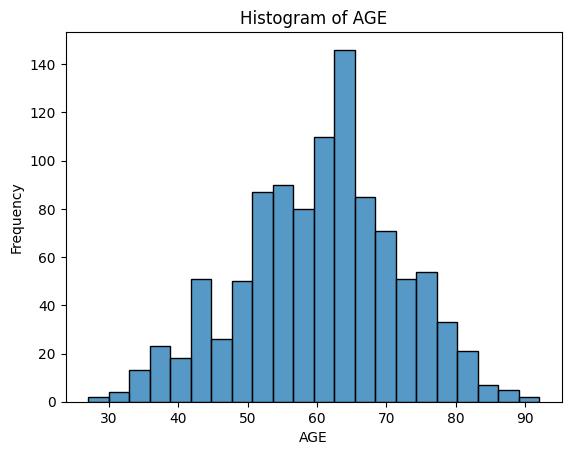

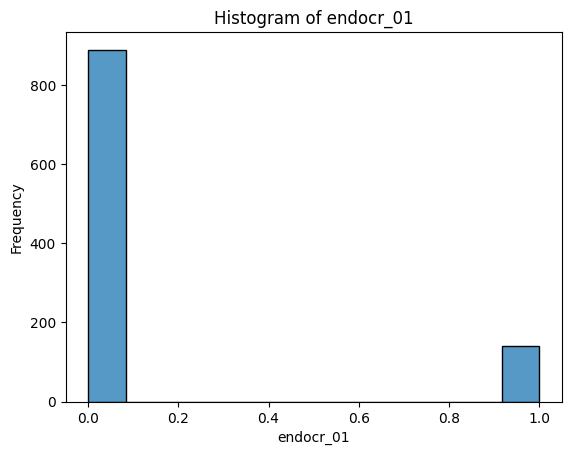

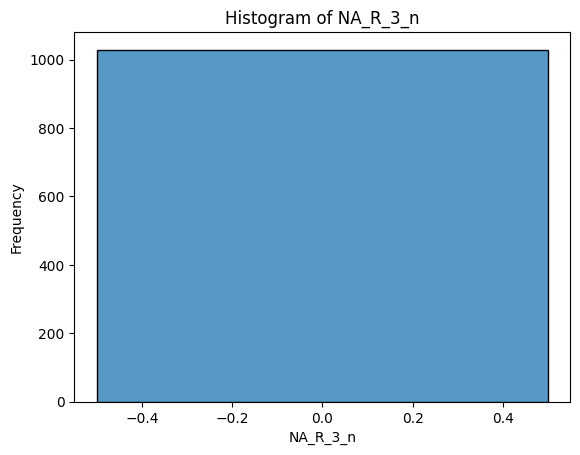

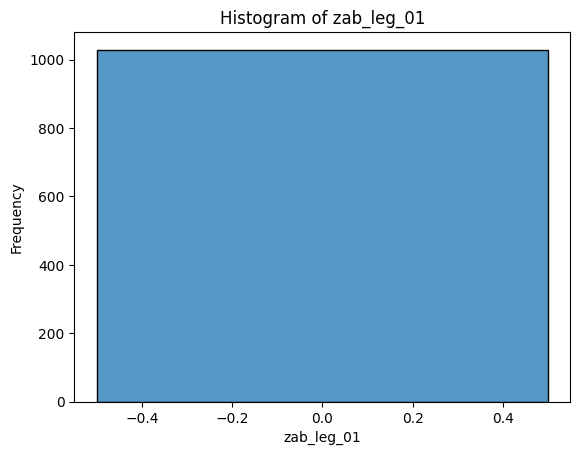

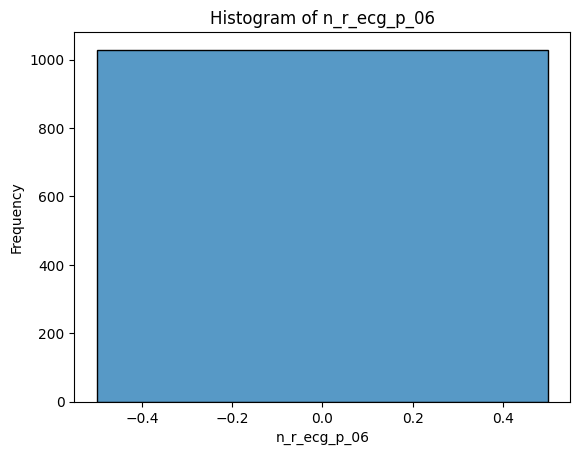

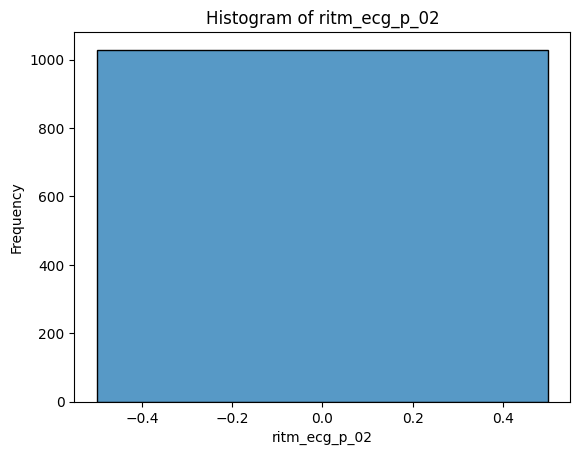

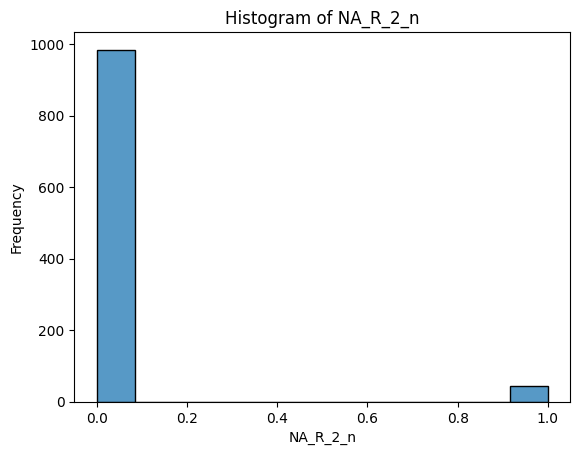

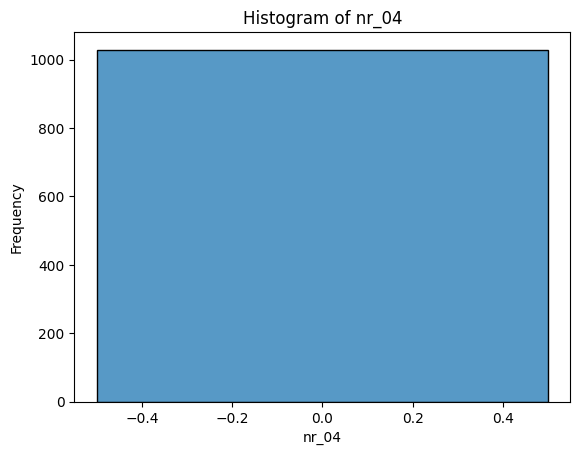

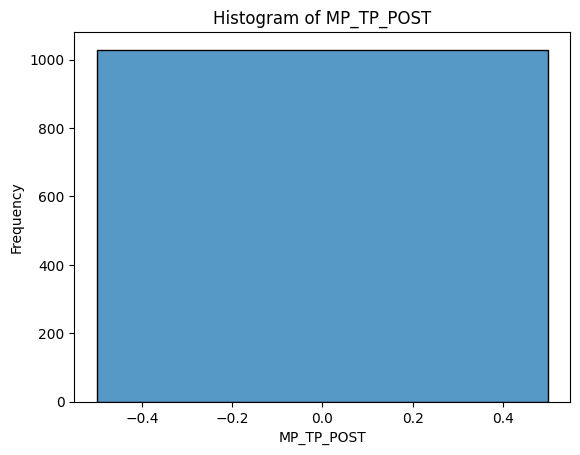

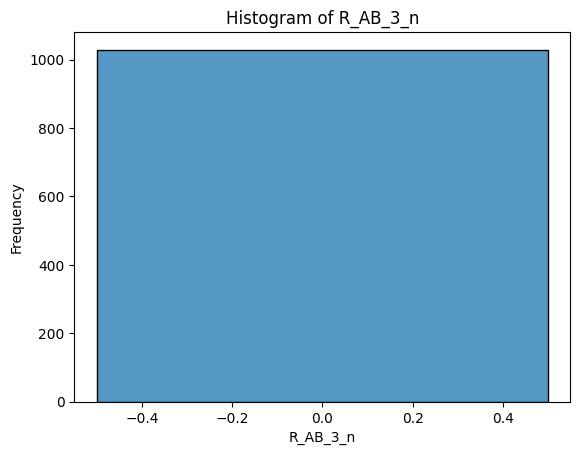

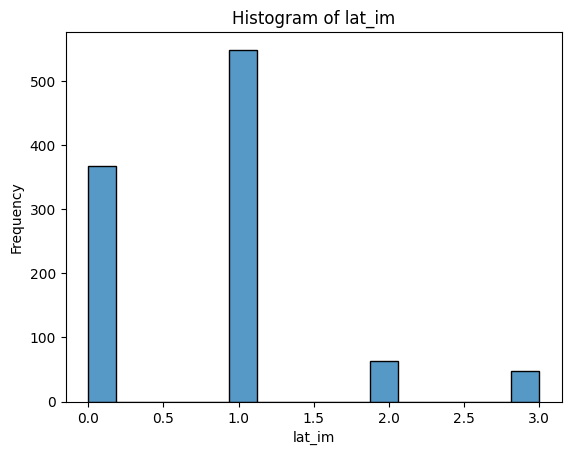

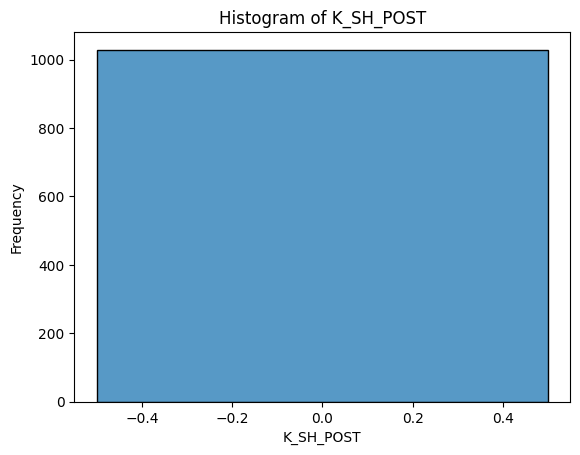

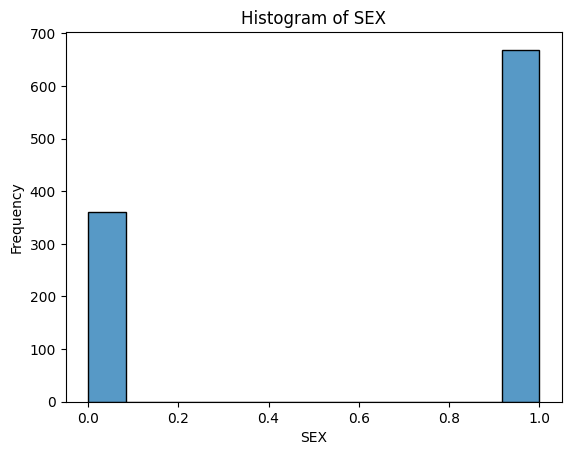

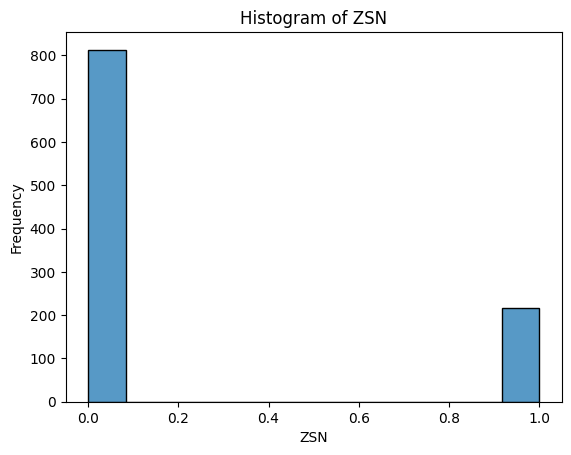

In [ ]:
# Histograms
def visualize_data(df):
    for column in df.columns:
        sns.histplot(df[column])
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

visualize_data(df_Visualization)

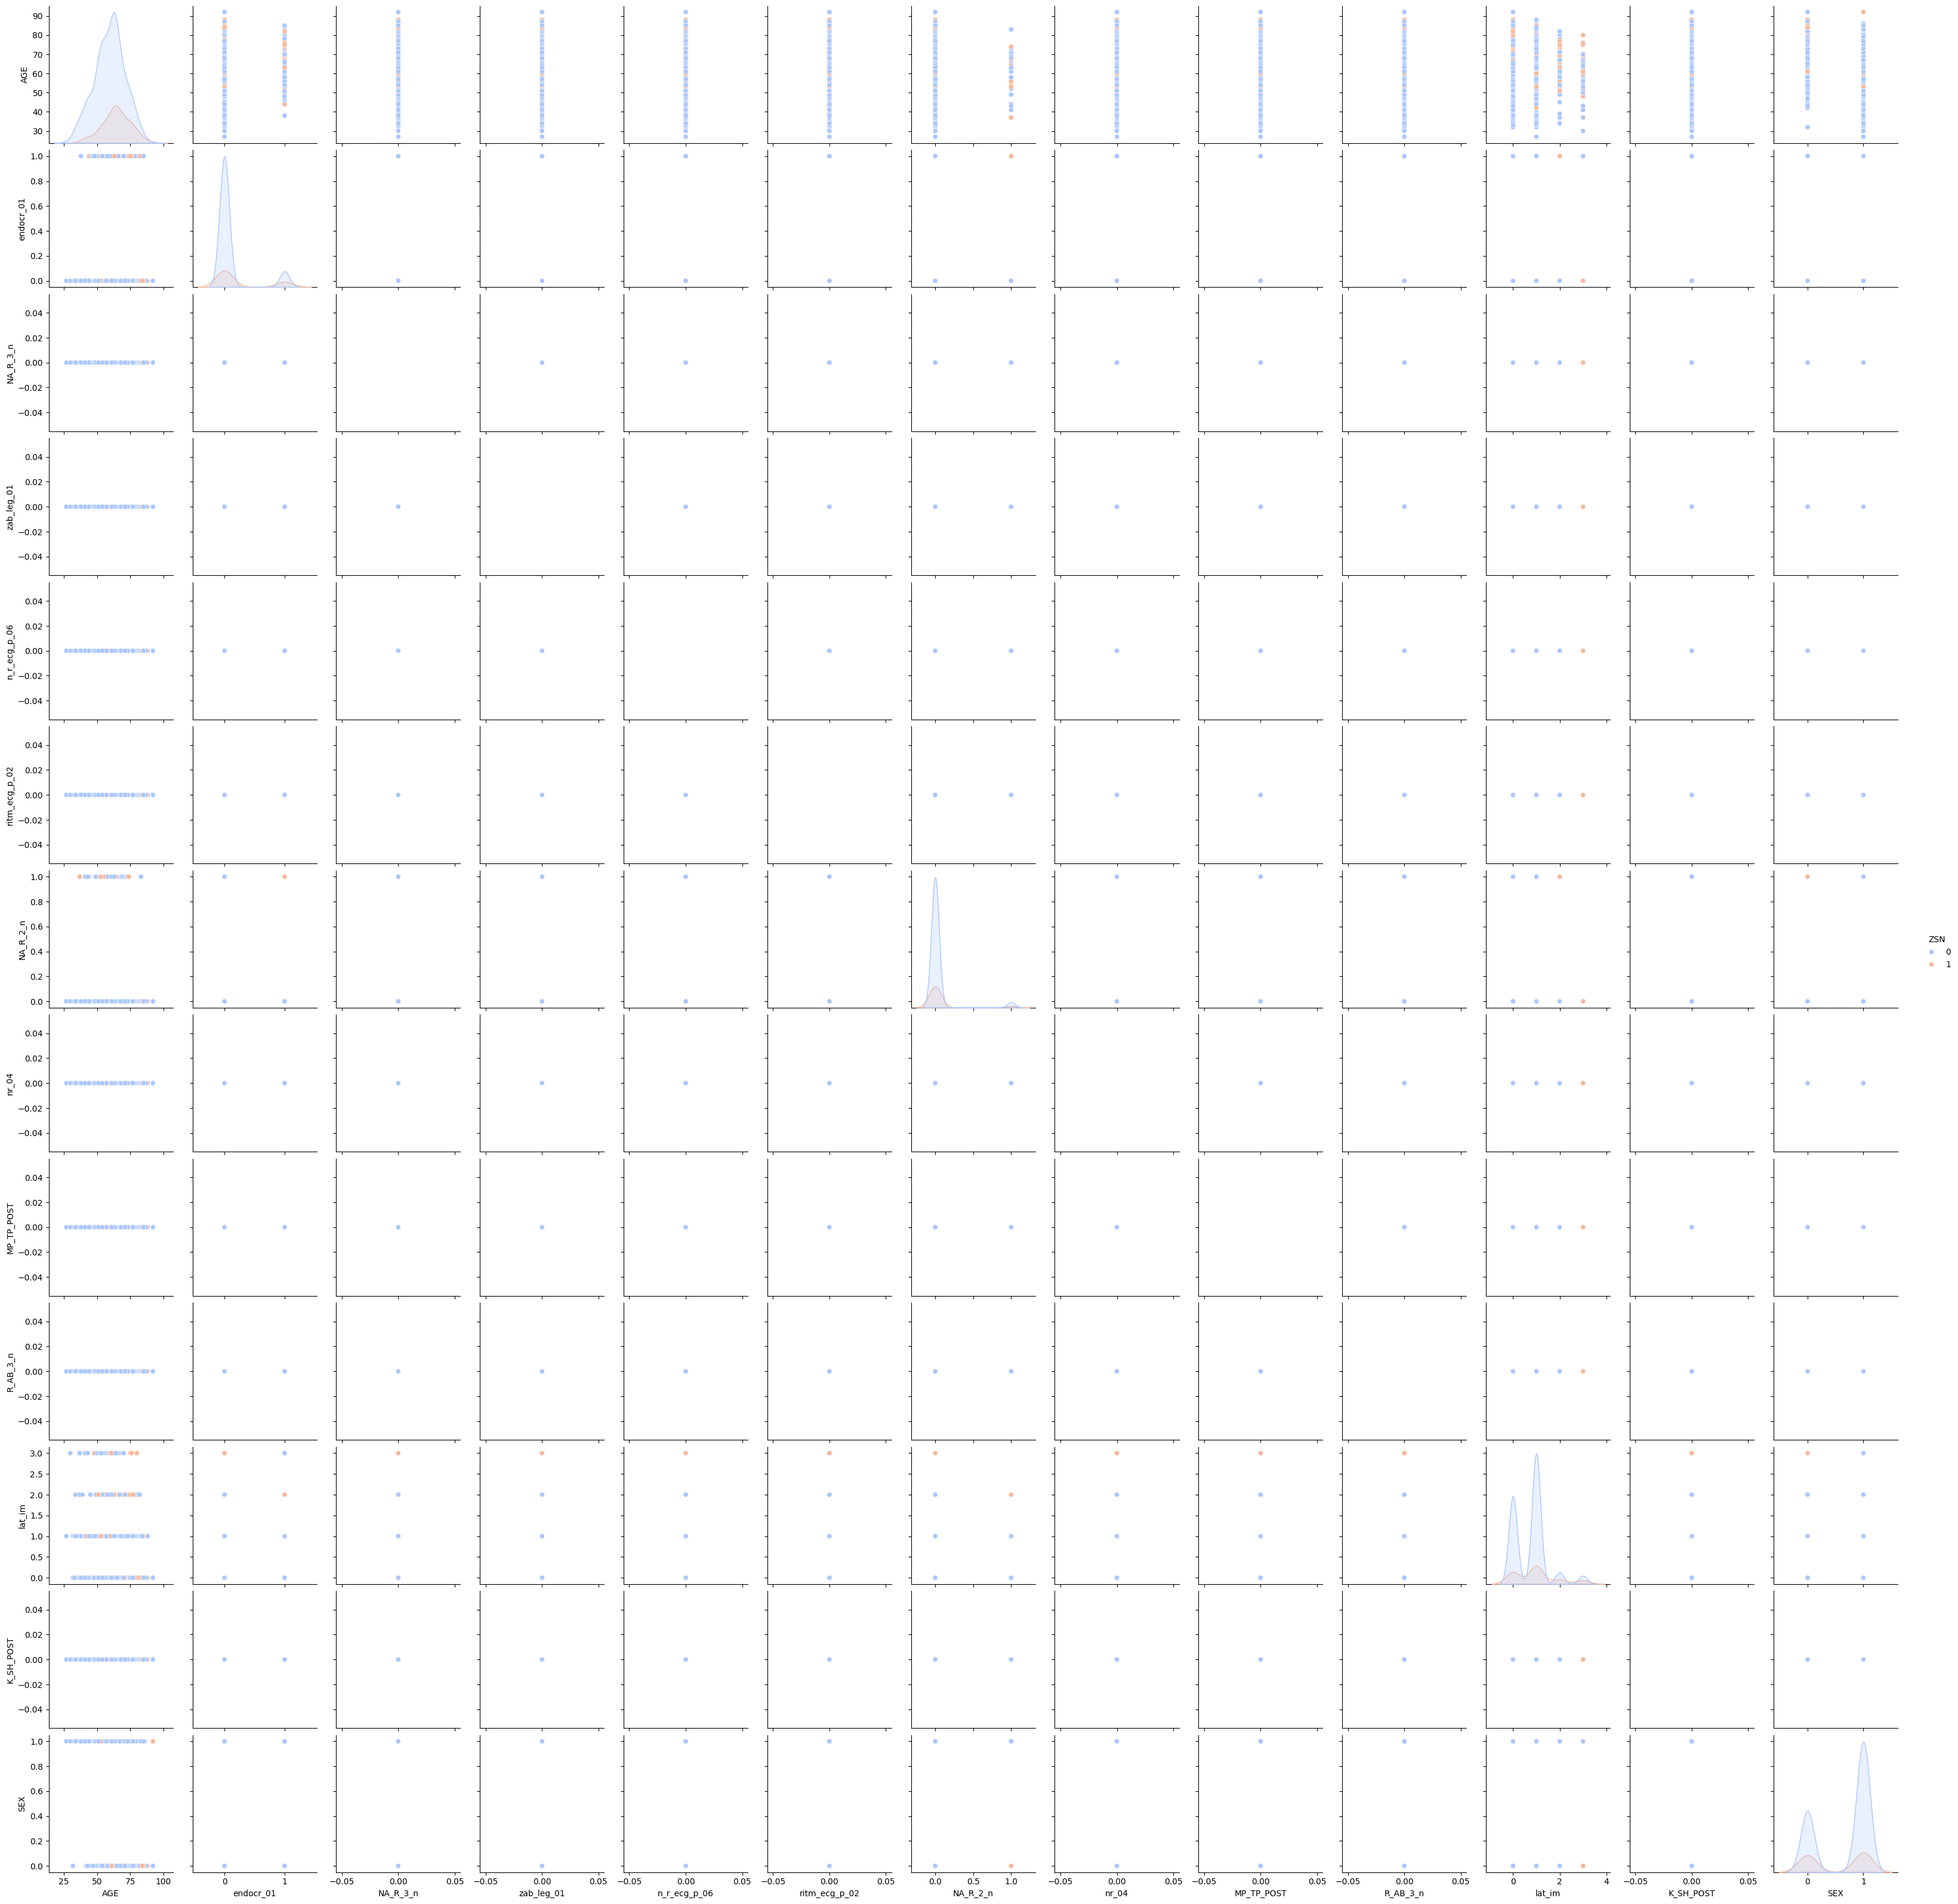

In [ ]:
# Pair Plots
final_cols = df_Visualization.columns.tolist()
sns.pairplot(df_Visualization[final_cols], hue='ZSN',
            palette = 'coolwarm')
plt.show()

## Model

In [ ]:
# Splitting the data into features and target
X = df_clean.drop("ZSN", axis=1)
y = df_clean['ZSN']

# Resampling Data
smote = SMOTE(sampling_strategy='auto', random_state=500)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=500)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1300, 13) (1300,)
Testing set shape: (326, 13) (326,)


Accuracy: 0.6380368098159509
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       168
           1       0.61      0.73      0.66       158

    accuracy                           0.64       326
   macro avg       0.64      0.64      0.64       326
weighted avg       0.65      0.64      0.64       326

Confusion Matrix:
[[ 93  75]
 [ 43 115]]


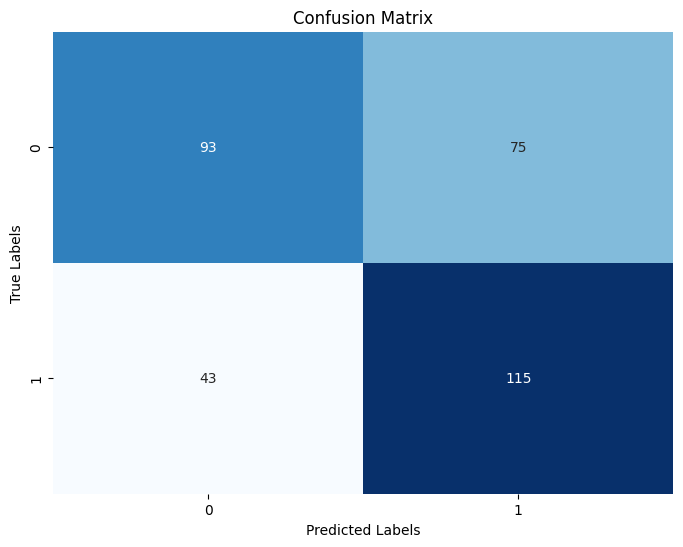

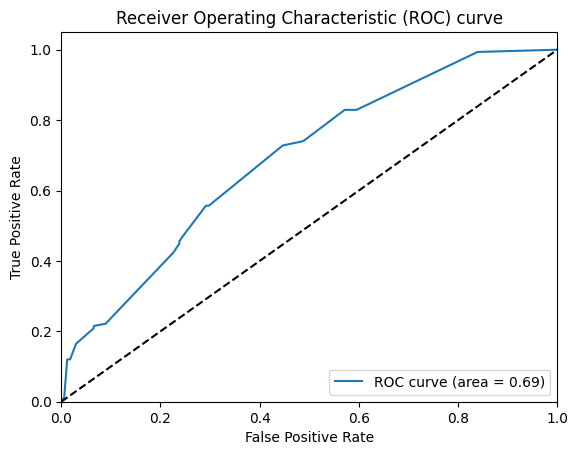

In [ ]:
# Baseline BernoulliNB Model

# Model
nbb_classifier = BernoulliNB()
nbb_classifier.fit(X_train, y_train)
y_pred = nbb_classifier.predict(X_test)

# Metrics
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# ROC Curve
probs = nbb_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'alpha': 0.5, 'binarize': 0.5, 'fit_prior': False}
Accuracy: 0.6993865030674846
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       168
           1       0.69      0.70      0.69       158

    accuracy                           0.70       326
   macro avg       0.70      0.70      0.70       326
weighted avg       0.70      0.70      0.70       326

Confusion Matrix:
[[118  50]
 [ 48 110]]


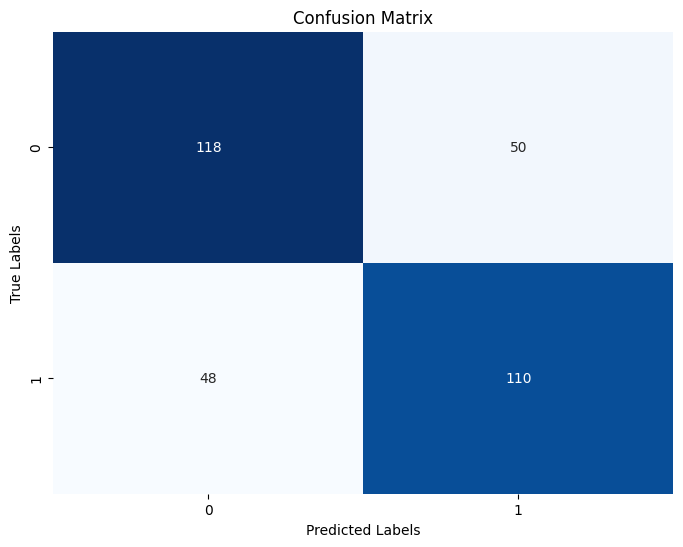

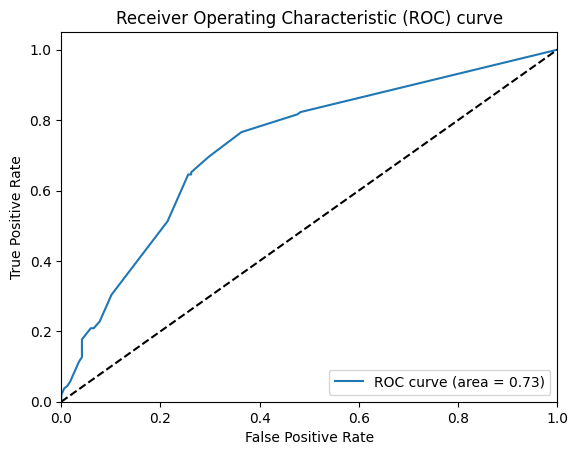

In [ ]:
# Tuned BernoulliNB

# Define the parameter grid for BernoulliNB
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.5, 5],
    'binarize': [None, 0.0, 0.1, 0.2, 0.5, 1.0],
    'fit_prior': [True, False]
}
# Initialize Grid Search with the BernoulliNB classifier and parameter grid
grid_search = GridSearchCV(estimator=nbb_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
# Perform Grid Search
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Prediction
best_classifier = grid_search.best_estimator_
y_pred_grid = best_classifier.predict(X_test)

# Metrics
# Accuracy
accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy:", accuracy)
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_grid))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_grid)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# ROC Curve
probs = best_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.6411042944785276
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       168
           1       0.66      0.54      0.59       158

    accuracy                           0.64       326
   macro avg       0.64      0.64      0.64       326
weighted avg       0.64      0.64      0.64       326

Confusion Matrix:
[[124  44]
 [ 73  85]]


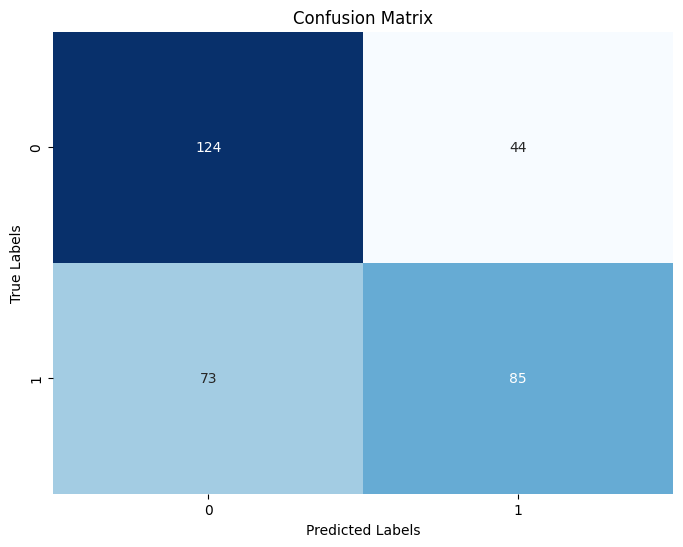

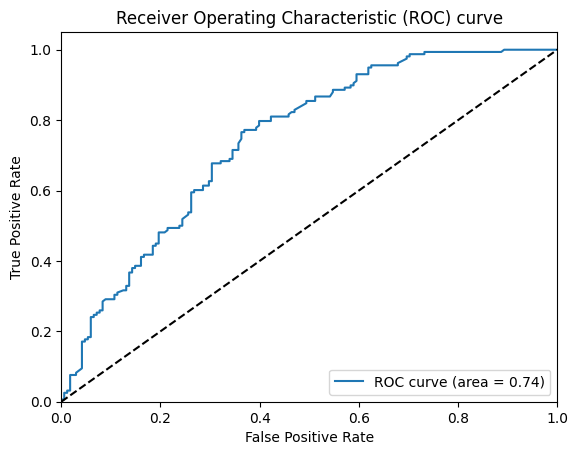

In [ ]:
# Baseline GaussianNB Model

# Model
nbg_classifier = GaussianNB()
nbg_classifier.fit(X_train, y_train)
y_pred = nbg_classifier.predict(X_test)

# Metrics
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# ROC Curve
probs = nbg_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'var_smoothing': 1.0}
Accuracy: 0.6503067484662577
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       168
           1       0.69      0.51      0.58       158

    accuracy                           0.65       326
   macro avg       0.66      0.65      0.64       326
weighted avg       0.66      0.65      0.64       326

Confusion Matrix:
[[132  36]
 [ 78  80]]


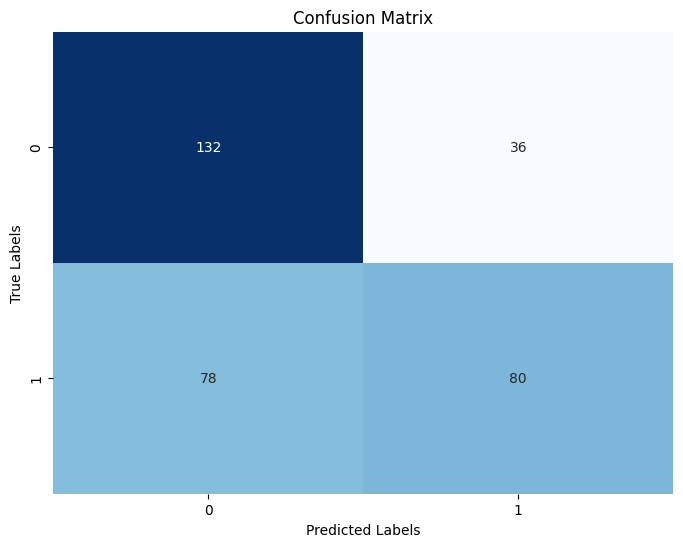

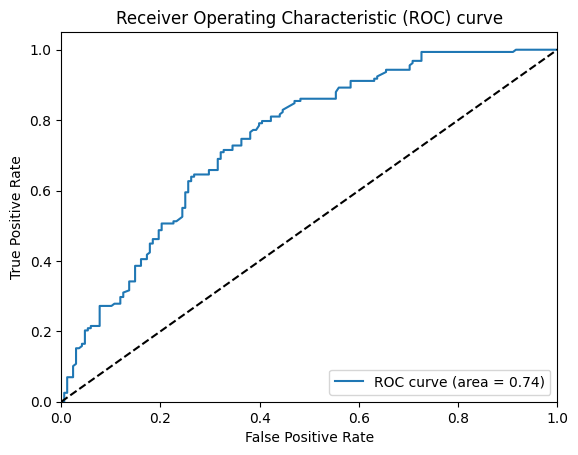

In [ ]:
# Tuned GaussianNB

# Define the parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
# Initialize Grid Search with the classifier and parameter grid
grid_search = GridSearchCV(estimator=nbg_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
# Perform Grid Search
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Prediction
best_classifier = grid_search.best_estimator_
y_pred_grid = best_classifier.predict(X_test)

# Metrics
# Accuracy
accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy:", accuracy)
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_grid))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_grid)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
# ROC Curve
probs = best_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()